<a href="https://colab.research.google.com/github/Kacper-W-Kozdon/notebook-testing-ivy/blob/main/Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IVY TRANSPILER

Installing kaggle and uploading the API key necessary to use it.

In [1]:
!pip install -q kaggle
from google.colab import files
from google.colab import userdata
import os
files.upload(); #Upload kaggle.json - you can get from the kaggle account settings, from the API section.

Saving kaggle.json to kaggle.json


Installing packages necessary to use torch's transformers.

In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 8.5 MB/s eta 0:00:00


To use the API, credentials need to be copied into the kaggle folder. If everything works, the output will show the list of available datasets.

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                  title                                          size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------  --------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
sudarshan24byte/online-food-dataset                  Online Food Dataset                             3KB  2024-03-02 18:50:30          16921        333  0.9411765        
sukhmandeepsinghbrar/heart-attack-dataset            Heart Attack Dataset                           16KB  2024-03-30 05:14:35           1089         25  1.0              
divu2001/coffee-shop-sales-analysis                  Coffee Shop Sales Analysis                      2MB  2024-03-30 10:57:57           1072         27  1.0              
syedanwarafridi/vehicle-sales-data                   Vehicle Sales Data                             19MB  2024-02-21 20:16:17          23626     

Preparing the ivy library.

In [4]:
#Insert the correct user when cloning the repos. Make sure that they are up-to-date.

!git clone "https://github.com/Kacper-W-Kozdon/demos.git"
!git clone "https://github.com/Kacper-W-Kozdon/ivy.git"
!pip install -U -q paddlepaddle ivy accelerate>=0.21.0 mlflow datasets>=2.14.5 nlp 2>/dev/null

Cloning into 'demos'...
remote: Enumerating objects: 3152, done.
remote: Counting objects: 100% (757/757), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 3152 (delta 665), reused 566 (delta 566), pack-reused 2395
Receiving objects: 100% (3152/3152), 16.81 MiB | 20.04 MiB/s, done.
Resolving deltas: 100% (1821/1821), done.
Cloning into 'ivy'...
remote: Enumerating objects: 189521, done.
remote: Counting objects: 100% (1317/1317), done.
remote: Compressing objects: 100% (648/648), done.
remote: Total 189521 (delta 933), reused 895 (delta 669), pack-reused 188204
Receiving objects: 100% (189521/189521), 164.37 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (152551/152551), done.


Next: import the ivy library and get the dataset.

In [5]:
import ivy
!kaggle datasets download -d danofer/sarcasm
!cp -f sarcasm.zip '/content/demos/Contributor_demos/Sarcasm Detection/'
!unzip '/content/demos/Contributor_demos/Sarcasm Detection/sarcasm.zip' -d '/content/demos/Contributor_demos/Sarcasm Detection/'

 95% 205M/216M [00:02<00:00, 118MB/s] 
100% 216M/216M [00:03<00:00, 69.4MB/s]
Archive:  /content/demos/Contributor_demos/Sarcasm Detection/sarcasm.zip
  inflating: /content/demos/Contributor_demos/Sarcasm Detection/test-balanced.csv  
  inflating: /content/demos/Contributor_demos/Sarcasm Detection/test-unbalanced.csv  
  inflating: /content/demos/Contributor_demos/Sarcasm Detection/train-balanced-sarc.csv.gz  
  inflating: /content/demos/Contributor_demos/Sarcasm Detection/train-balanced-sarcasm.csv  


Import the libraries suggested in the model which is to be transpiled.

In [6]:
# Import necessary libraries
import pandas as pd  # For data manipulation and analysis
import gc  # For garbage collection to manage memory
import re  # For regular expressions
import numpy as np  # For numerical operations and arrays
import paddle

# Libraries to accompany torch's transformers
import tqdm
import boto3
import requests
import regex
import sentencepiece
import sacremoses

import warnings  # For handling warnings
warnings.filterwarnings("ignore")  # Ignore warning messages

import tensorflow as tf
import torch  # PyTorch library for deep learning
from transformers import AutoModel, AutoTokenizer  # Transformers library for natural language processing
from transformers import TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding  # Transformers components for text processing
from transformers import AutoModelForSequenceClassification  # Transformer model for sequence classification

import accelerate

from nlp import Dataset  # Import custom 'Dataset' class for natural language processing tasks
from imblearn.over_sampling import RandomOverSampler  # For oversampling to handle class imbalance
import datasets  # Import datasets library
from datasets import Dataset, Image, ClassLabel  # Import custom 'Dataset', 'ClassLabel', and 'Image' classes
from transformers import pipeline  # Transformers library for pipelines
from bs4 import BeautifulSoup  # For parsing HTML content

import matplotlib.pyplot as plt  # For data visualization
import itertools  # For working with iterators
from sklearn.metrics import (  # Import various metrics from scikit-learn
    accuracy_score,  # For calculating accuracy
    roc_auc_score,  # For ROC AUC score
    confusion_matrix,  # For confusion matrix
    classification_report,  # For classification report
    f1_score  # For F1 score
)

from datasets import load_metric  # Import load_metric function to load evaluation metrics

from tqdm import tqdm  # For displaying progress bars
tqdm.pandas()  # Enable progress bars for pandas operations

Set the seeds.

In [7]:
tf.keras.utils.set_random_seed(0)
torch.manual_seed(0)
paddle.seed(0)

Get the API key for ivy transpiler from your account and upload it to the project. Move it to the correct directory.

In [8]:
files.upload(); #Upload key.pem - you can get from the kaggle account settings, from the API section.

Saving key.pem to key.pem


In [9]:
!mkdir ~/.ivy #It might be necessary to change ".ivy" to "ivy".
!cp key.pem ~/.ivy/

First we're loading the tokenizer and the model from torch. All of the basic set-up instructions can be found here: https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/huggingface_pytorch-transformers.ipynb#scrollTo=72d8f2de

In [22]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

sequence_classifier = torch.hub.load('huggingface/pytorch-transformers', 'modelForSequenceClassification', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
from ivy.stateful.module import Module
from ivy.stateful.sequential import Sequential
from ivy.stateful.layers import *
from ivy.stateful.losses import *
from ivy.stateful.optimizers import *
from ivy.stateful.activations import *
from ivy.stateful.initializers import *
from ivy.stateful.norms import *

In [25]:
ivy.set_backend("tensorflow")
ivy.set_soft_device_mode(True)
#tokenizer_tf = ivy.transpile(tokenizer, source="torch", to="tensorflow")
#model_pd = ivy.to_ivy_module(model)
#model_pd = model_pd.trace_graph()
#model_pd = model_pd.set_backend("tensorflow")
model_tf = ivy.transpile(model, source="torch", to="tensorflow")
sequence_classifier_tf = ivy.transpile(sequence_classifier, source="torch", to="tensorflow")

In [13]:
df = pd.read_csv("/content/demos/Contributor_demos/Sarcasm Detection/train-balanced-sarcasm.csv")
df = df.drop_duplicates()
df = df.rename(columns={'comment': 'title'})
df = df[['label', 'title']]
df = df[~df['label'].isnull()]
df = df[~df['title'].isnull()]
df.sample(5)

label                                              title
242003      0  Congrats to winners and and a BIG thank you to...
861046      1  Totally did not expect a screenshot with "No m...
568738      1                 the technology isnt there yet guys
419147      1  I dunno man, pretty sure this shit happens in ...
154503      1                        Eww gross, she's not human!

In [14]:
def count_words(text: str) -> int:
  return len(text.split())

def count_symbols(text: str) -> int:
  return len("".join(text.split()))

def symbol_to_word_ratio(text: str) -> float:
  return count_symbols(text)/count_words(text)

def upper_lower_ratio(text: str) -> float:
  text = "".join(text.split())
  return sum(1 for c in text if c.isupper())/(max([sum(1 for c in text if c.islower()), 1]))

df['word_count'] = df["title"].apply(count_words)
df['symbol_count'] = df["title"].apply(count_symbols)
df["upper_lower_ratio"] = df["title"].apply(upper_lower_ratio)
df["symbol_to_word_ratio"] = df["title"].apply(symbol_to_word_ratio)
df.sample(5)

label                                              title  word_count  \
797130      0                                           Routine?           1   
464103      0   I think Apollos will be a good fit for the team.          11   
96237       0  It costs 400 000 000$ to fire this weapon for ...          12   
598115      0                            found the city slicker.           4   
217679      0  If you think regular St Marys is bad, take a l...          15   

        symbol_count  upper_lower_ratio  symbol_to_word_ratio  
797130             8           0.166667              8.000000  
464103            38           0.057143              3.454545  
96237             46           0.031250              3.833333  
598115            20           0.000000              5.000000  
217679            54           0.130435              3.600000

A few plots to see some some characteristics of the data.

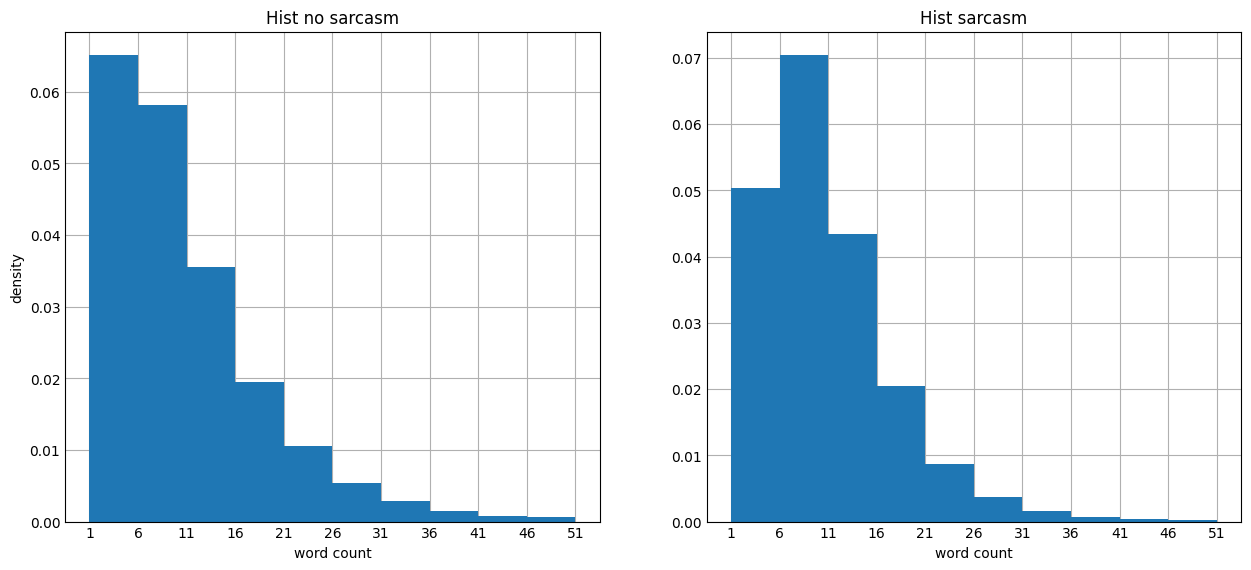

In [15]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["word_count"] <= 51)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["word_count"] <= 51)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["word_count"])]
df_sarc = df_sarc[np.isfinite(df_sarc["word_count"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["word_count"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["word_count"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("word count")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("word count")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()

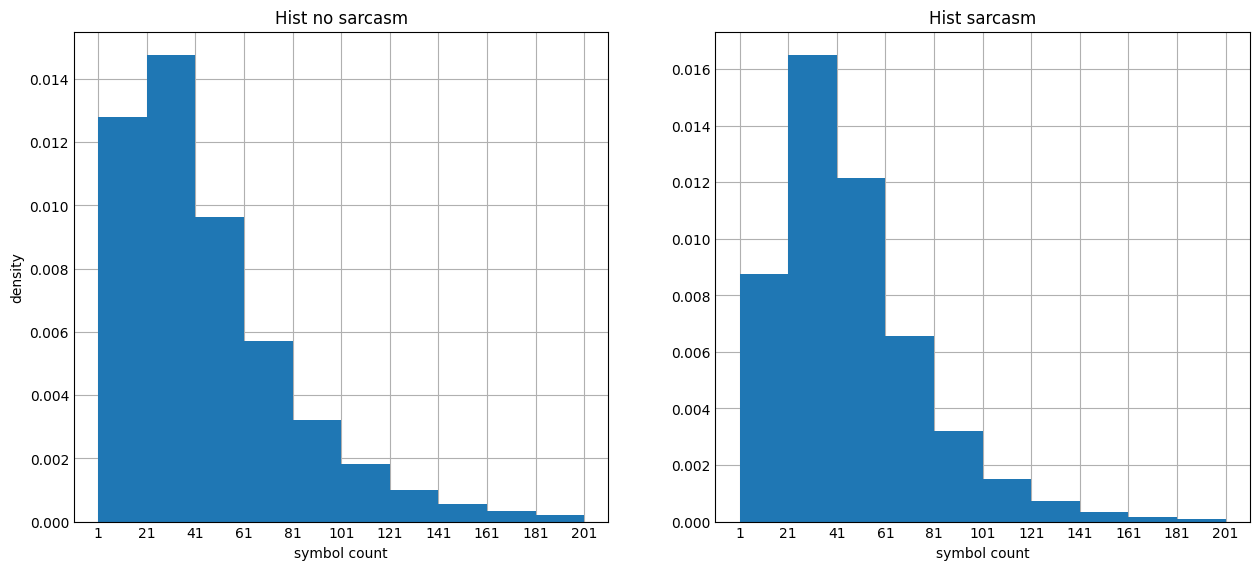

In [16]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["symbol_count"] <= 201)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["symbol_count"] <= 201)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["symbol_count"])]
df_sarc = df_sarc[np.isfinite(df_sarc["symbol_count"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["symbol_count"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["symbol_count"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("symbol count")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("symbol count")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()

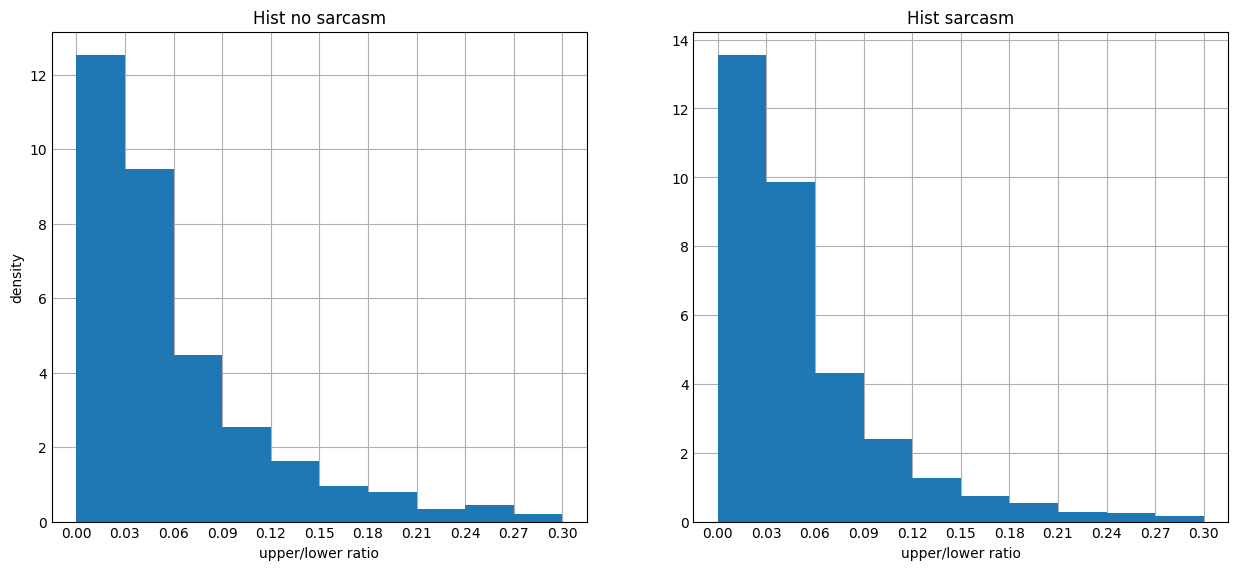

In [17]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["upper_lower_ratio"] <= 0.3)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["upper_lower_ratio"] <= 0.3)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["upper_lower_ratio"])]
df_sarc = df_sarc[np.isfinite(df_sarc["upper_lower_ratio"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["upper_lower_ratio"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["upper_lower_ratio"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("upper/lower ratio")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("upper/lower ratio")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()

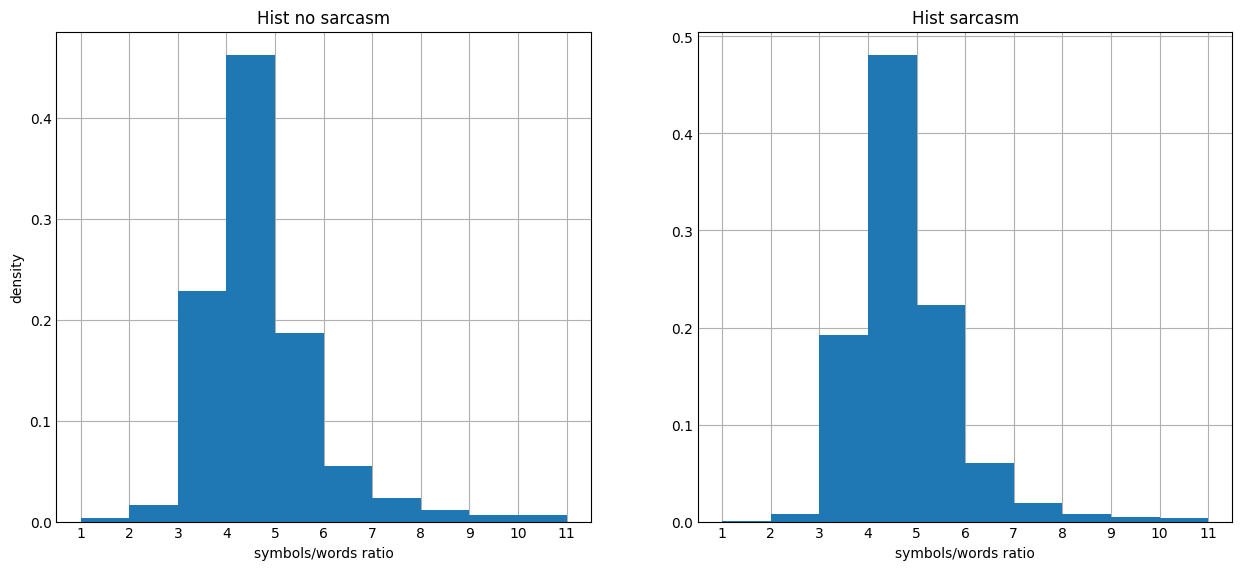

In [18]:
df_no_sarc = df.where(df["label"] == 0)
df_no_sarc = df_no_sarc.where(df_no_sarc["symbol_to_word_ratio"] <= 11)
df_sarc = df.where(df["label"] == 1)
df_sarc = df_sarc.where(df_sarc["symbol_to_word_ratio"] <= 11)
df_no_sarc = df_no_sarc[np.isfinite(df_no_sarc["symbol_to_word_ratio"])]
df_sarc = df_sarc[np.isfinite(df_sarc["symbol_to_word_ratio"])]
plt.style.use('_mpl-gallery-nogrid')

hist_df_no_sarc, bin_edges_no = np.histogram(df_no_sarc["symbol_to_word_ratio"].values, density=True)
hist_df_sarc, bin_edges = np.histogram(df_sarc["symbol_to_word_ratio"].values, density=True)
# plot:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

bin_mids_no = [(bin_edges_no[i+1] + bin_edges_no[i])/2 for i in range(len(bin_edges_no) - 1)]
bin_mids = [(bin_edges[i+1] + bin_edges[i])/2 for i in range(len(bin_edges) - 1)]
ax1.bar(bin_mids_no, hist_df_no_sarc, width=bin_edges_no[1] - bin_edges_no[0])
ax2.bar(bin_mids, hist_df_sarc, width=bin_edges[1] - bin_edges[0])
ax1.set_title("Hist no sarcasm")
ax1.set_ylabel("density")
ax1.set_xlabel("symbols/words ratio")
ax1.set_xticks(bin_edges_no)
ax1.grid(True)
ax2.set_title("Hist sarcasm")
ax2.set_xlabel("symbols/words ratio")
ax2.set_xticks(bin_edges)
ax2.grid(True)
plt.show()

Checking if the tokenizer, encoder/decoder and classifier work.

In [19]:
input = df["title"][1]
print(f"The raw input: \n{input}\n")
token = tokenizer(input, return_tensors="pt", add_special_tokens=True)
print(f"The token: \n{token}\n")
with torch.no_grad():
  encoded_token = model(**token)
print(f"The encoded token: \n{encoded_token}\n")

The raw input: 
You do know west teams play against west teams more than east teams right?

The token: 
{'input_ids': tensor([[ 101, 1192, 1202, 1221, 1745, 1929, 1505, 1222, 1745, 1929, 1167, 1190,
         1746, 1929, 1268,  136,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The encoded token: 
BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.4462,  0.2160, -0.1071,  ...,  0.0152,  0.0267,  0.0355],
         [ 0.0494,  0.1604,  0.2987,  ...,  0.5141,  0.0322,  0.2827],
         [ 0.4538,  0.4593, -0.2480,  ...,  1.0495, -0.6544, -0.0112],
         ...,
         [-0.5150, -0.2680,  0.5978,  ...,  1.0094,  0.1459, -0.1362],
         [ 0.6309, -0.1056, -0.2410,  ...,  0.7903, -0.3774,  0.2999],
         [ 0.8112, -0.3091, -0.4682,  ...,  0.2833,  0.3041, -0.4745]]]), pooler_output=tensor([[-0.6787,  0.4098,  0.9998, -0.9932,  0.9582,  0

Checking if the transpiled tokenizer, encoder/decoder and classifier work.

In [26]:
input = df["title"][1]
print(f"The raw input: \n{input}\n")
token = tokenizer.encode(input, return_tensors="tf", add_special_tokens=True)
print(f"The token: \n{token}\n")
#input_ids, token_type_ids, attention_mask = token["input_ids"], token["token_type_ids"], token["attention_mask"]
encoded_token = model_tf(token)
print(f"The encoded token: \n{encoded_token}\n")

The raw input: 
You do know west teams play against west teams more than east teams right?

The token: 
[[ 101 1192 1202 1221 1745 1929 1505 1222 1745 1929 1167 1190 1746 1929
  1268  136  102]]



RuntimeError: Exception encountered when calling layer 'private___keras_model_4' (type __KerasModel).

Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

Call arguments received by layer 'private___keras_model_4' (type __KerasModel):
  • args=('tf.Tensor(shape=(1, 17), dtype=int32)',)
  • kwargs={'training': 'None'}

A quick check whether transpiling to paddle works as intended.

In [27]:
class Network(torch.nn.Module):

    def __init__(self):
     super().__init__()
     self._linear = torch.nn.Linear(3, 3)

    def forward(self, x):
     return self._linear(x)

x = torch.tensor([1., 2., 3.])
net = Network()
net(x)

tensor([ 0.1816, -0.4204,  0.3818], grad_fn=<ViewBackward0>)

In [28]:
ivy.set_backend("paddle")
net_pd = ivy.transpile(net, source="torch", to="paddle")
x_pd = paddle.to_tensor([1., 2., 3.])
net_pd(x_pd)

Tensor(shape=[3], dtype=float32, place=Place(cpu), stop_gradient=False,
       [ 0.18157756, -0.42038253,  0.38175309])

Setting up the classifier based on BERT's sequence classifier model.

In [87]:
class Classifier(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(Classifier, self).__init__()
        self.tokenizer = tokenizer
        self.model = sequence_classifier
        self.softmax = torch.nn.functional.softmax
        self.argmax = torch.argmax

    def forward(self, x):
        x = self.tokenizer(x, return_tensors="pt", add_special_tokens=True, padding=True, truncation=True)
        x = self.model(**x)
        x = self.softmax(x["logits"], dim=1)
        x = self.argmax(x, dim=1)
        return x


ivy.set_backend("paddle")
classifier = Classifier()
classifier_pd = ivy.transpile(classifier, source="torch", to="paddle")

In [101]:
input = df["title"][1]
input2 = df["title"][5]
input3 = df["title"][2]

print(input)
print(classifier([input]))
print(classifier([input, input2, input3]))

You do know west teams play against west teams more than east teams right?
tensor([0])
tensor([0, 0, 0])


In [89]:
print(classifier_pd(input))
print(f"Layers: {len(classifier_pd.parameters())}")

Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [0])
Layers: 201


In [104]:
print(classifier_pd(input))
print(classifier_pd([input, input2, input3]))
print(paddle.to_tensor(list(map(classifier_pd, [input, input2, input3]))))

Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [0])
Tensor(shape=[1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [0])
Tensor(shape=[3, 1], dtype=int64, place=Place(cpu), stop_gradient=True,
       [[0],
        [0],
        [0]])


Setting up the training and training the model.

In [31]:
def one_hot(input):

  input = paddle.to_tensor(input)
  return paddle.nn.functional.one_hot(input, num_classes=2)

sample = df.sample(5)
sample['label'] = sample['label'].apply(one_hot, "columns")

type(sample["label"])
for label in sample["label"]:
  print(label)


Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=True,
       [0., 1.])
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=True,
       [1., 0.])
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=True,
       [1., 0.])
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=True,
       [1., 0.])
Tensor(shape=[2], dtype=float32, place=Place(cpu), stop_gradient=True,
       [0., 1.])


In [32]:
df.drop(['word_count',	'symbol_count',	'upper_lower_ratio',	'symbol_to_word_ratio'], axis=1, inplace=True)
gc.collect()

14192

In [33]:
import paddle.distributed as dist
def one_hot(input):
  input = paddle.to_tensor(input)
  return paddle.nn.functional.one_hot(input, num_classes=2)



# if type(df['label'][1]) is np.int64:
#   df['label_one_hot'] = df['label'].apply(one_hot, "columns")

# train_dataset = df[['title', 'label_one_hot']]
# test_dataset = df[['title', 'label_one_hot']]
train_dataset = df[['title', 'label']]
test_dataset = df[['title', 'label']]

In [ ]:
# sample_train = train_dataset.sample(5)
# for entry, label in zip(sample_train["title"], sample_train["label_one_hot"]):
#   print(entry, label)

Switching from pandas.dataframe to paddle.io.Dataset for the convenience of use and compatibility.

In [34]:
import numpy as np
from paddle.io import Dataset

# define a random dataset
class pd_Dataset(Dataset):
    def __init__(self, df):
      super().__init__()
      self.num_samples = df['title'].size
      self.data = [[entry[0], entry[1]] for entry in zip(df["title"], df["label"])]

    def __getitem__(self, idx):
        title = self.data[idx][0]
        label = self.data[idx][1]
        return title, label

    def __len__(self):
        return self.num_samples

train_dataset_pd = pd_Dataset(train_dataset)

train_loader = paddle.io.DataLoader(train_dataset_pd, batch_size=64, shuffle=True)


In [97]:
for batch_id, data in enumerate(train_loader()):
  if batch_id >= 1:
    break
  print(data[0])
  print(list(map(classifier_pd, data[0])))

['This cat is so beautiful that it made me gasp and then coo at the photo.', "That's exactly what will happen.", 'Feeding swans by the river when I was 2 and we lived in Germany.', 'Alright cool, thanks!', "it doesn't really matter about the technique that they use to do it though because the complaint here is about blind passes", 'This is like one of those fake reviews posted on google maps', 'We struggled to close the last 3.. All 3 of our losses could easily have been wins with better 4th quarter coaching..', 'But if they do it 4 hours a day for a few weeks, they will get FREE MONEY.', "That's how easy he is ; )", 'Forgot Asp Scout, seriously it is like you put zero effort into this.', 'Do the Blu-ray Disc Movie specifications apply to games or other media though?', 'Those are the best kinds of gifts.', 'Utopia my ass, everyone knows Finland reaches absolute zero and remain in total darkness 8 months a year', 'I thought you got banned from this subreddit?', 'Let me guess... Australi

KeyboardInterrupt: 

In [105]:

def train(model):

  parameters = model.parameters()
  adam = paddle.optimizer.Adam(learning_rate=0.001, parameters=model.parameters())
  loss_fn = paddle.nn.CrossEntropyLoss()
  metric = paddle.metric.Accuracy()
  epochs = 2
  classifier = paddle.DataParallel(model)

  for epoch in range(epochs):
    for batch_id, data in enumerate(train_loader()):
      x_data = data[0]
      y_data = data[1]
      predicts = paddle.to_tensor(list(map(classifier, x_data))) # The transpiled model seems to have problems with inputs, so instead of feeding it a container, we map onto one.
      acc = paddle.metric.accuracy(predicts, y_data) # This needs to be corrected.
      loss = loss_fn(predicts, y_data)
      loss.backward()
      if batch_id % 100 == 0:
          print("epoch: {}, batch_id: {}, loss is: {}, acc is: {}".format(epoch, batch_id, loss.numpy(), acc.numpy()))
      adam.step()
      adam.clear_grad()

In [39]:
for batch_id, data in enumerate(train_loader()):
  print(data[0], data[1])
  print(classifier_pd(data[0]))
  if batch_id >= 1:
    break

['But he said MANkind, which is sexist and patriarchal, it should be humankind, you sexist pigs.', 'Might also have to do with the fact that electricity costs more in higher demand areas(city) then lower demand areas(suburb).', 'I have a grill guard for a reason', 'Its never victim hood when non-Hindus feel insecure.', 'Could be sugar that helped, not meat?', 'oh cool thank you for the convincing argument and enlightening input', 'yeah, there was a few times on the campaign trail a couple months back that he looked pretty rough, but i listened to a couple speeches from the past few days and he looked and sounded fine.', "Stanley Kubrick's 7th best film is still an all-time great film!", 'The French suffering from that jet lag.', 'Winning ranked 3/10 being unranked, wins teamfight and now the match is gone.. :(', 'Here is a headline that uses the word illegal wiretap, but not the word TREASON.', "Yeah this match doesn't matter like the finals, they are playing for peanuts now.", "Hmm, m

In [ ]:
print(classifier_pd)

In [37]:
train(classifier_pd)

TypeError: 'Accuracy' object is not callable